In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from grow_hail_master import hail_model

In [2]:
# Load in the datasets that will be used for parameters sampling
# ds_hail contains the coupled trajectory-specific parameters that modify maximum liquid water content and maximum vertical velocity
ds_hail  = xr.open_dataset('data/coupled_trajectory_scaling_parameters.nc')
# ds_storm contains the coupled environmental parameters taken from storm proxy soundings (Warren et al., 2021, MWR)
ds_storm = xr.open_dataset('data/coupled_environmental_parameters.nc')
# ds_all is a collection of randomly selected parameters following the EX Monte Carlo simulation from Spychalla and Kumjian (2025b)
ds_all   = xr.open_dataset('data/all_parameters_example_dataset.nc')

In [3]:
# Run the hail model: sampling 1000 unique parameter combinations with 5 trajectory realizations of each.
# By default when no 'sampling_method' is passed, all model parameters are sampled according to the EX Monte Carlo simulation
hail_out_ex = hail_model( n_samples=1000, n_realizations=5, n_chunks=1 )

100%|██████████| 1/1 [00:06<00:00,  6.87s/it]


In [4]:
# Pull out the output data: final maximum dimension, total time aloft, and final location
D_max = hail_out_ex.D_max.values
t_tot = hail_out_ex.t_tot.values
lofted = hail_out_ex.lofted.values

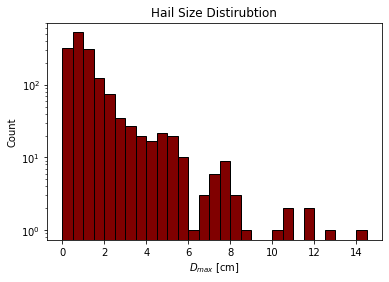

In [5]:
# Plot the distribution of hail sizes of the hailstones that hit the ground
plt.figure()
plt.hist(D_max[~lofted]*100, bins=np.arange(0,np.nanmax(D_max)*100+0.5,0.5), color='maroon', edgecolor='k')
plt.yscale('log')
plt.title('Hail Size Distirubtion')
plt.xlabel(r'$D_{max}$ [cm]')
plt.ylabel('Count')
plt.show()

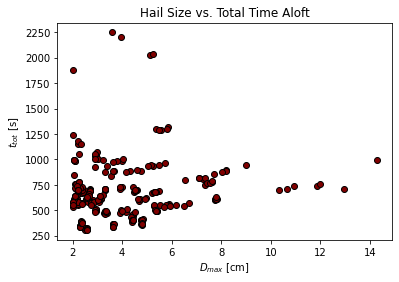

In [12]:
# Make a scatter plot of hail size vs. total time aloft
large_ground_hailstones = np.logical_and(~lofted, D_max > 0.02)
plt.figure()
plt.scatter(D_max[large_ground_hailstones]*100, t_tot[large_ground_hailstones], color='maroon', edgecolor='k')
# plt.yscale('log')
plt.title('Hail Size vs. Total Time Aloft')
plt.xlabel(r'$D_{max}$ [cm]')
plt.ylabel(r'$t_{tot}$ [s]')
plt.show()

In [13]:
# Run the hail model again with coupled sampling:
hail_out_mp = hail_model( n_samples=1000, n_realizations=5, n_chunks=1, sampling_method='mp', ds_hail=ds_hail, ds_storm=ds_storm )

100%|██████████| 1/1 [00:07<00:00,  7.07s/it]


In [14]:
# Pull out output from coupled simulation:
D_max_mp = hail_out_mp.D_max.values
t_tot_mp = hail_out_mp.t_tot.values
lofted_mp = hail_out_mp.lofted.values

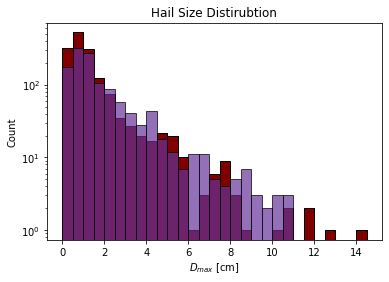

In [15]:
# Compare the size distributions for the coupled and uncoupled simulations
plt.figure()
plt.hist(D_max[~lofted]*100, bins=np.arange(0,np.nanmax(D_max)*100+0.5,0.5), color='maroon', edgecolor='k')
plt.hist(D_max_mp[~lofted_mp]*100, bins=np.arange(0,np.nanmax(D_max_mp)*100+0.5,0.5), color='rebeccapurple', edgecolor='k', alpha=0.7)
plt.yscale('log')
plt.title('Hail Size Distirubtion')
plt.xlabel(r'$D_{max}$ [cm]')
plt.ylabel('Count')
plt.show()

In [17]:
# The same can be done for coupled inputs with an exponential initial size distribution (SP simulation) and for manually defined inputs.
# For example, lets run a coupled simulation with exponential output, then run the same simulation again by passing in the output dataset to "hail_model" with sampling_method='manual'
hail_out_sp = hail_model( n_samples=1000, n_realizations=5, n_chunks=1, sampling_method='sp', ds_hail=ds_hail, ds_storm=ds_storm )
# Take the output and subsample so that only one realization remains for initial parameter sampling
ds_resample = hail_out_sp.sel(realization=0)
# Drop all output data from the dataset so only input parameters remain
ds_resample = ds_resample.drop(['t_tot', 'D_max', 'lofted'])
# Rerun the hail model with ds_all=ds_resample
hail_out_manual = hail_model( n_samples=1000, n_realizations=5, n_chunks=1, sampling_method='manual', ds_all=ds_resample )

100%|██████████| 1/1 [00:07<00:00,  7.37s/it]


In [20]:
# Pull out output from coupled simulation:
D_max_sp1 = hail_out_sp.D_max.values
t_tot_sp1 = hail_out_sp.t_tot.values
lofted_sp1 = hail_out_sp.lofted.values

# Pull out output from coupled simulation:
D_max_sp2 = hail_out_manual.D_max.values
t_tot_sp2 = hail_out_manual.t_tot.values
lofted_sp2 = hail_out_manual.lofted.values

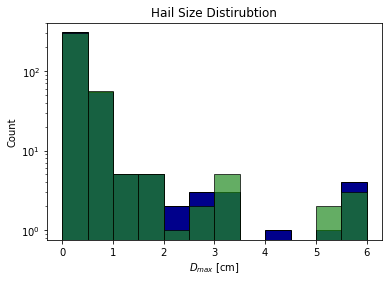

In [21]:
# Compare the size distributions for the two coupled simulations with exponential hail embryo sizes
# Notice that although the input parameters were the same, there is some variation in output sizes because of the model's built-in stochasticiticy
plt.figure()
plt.hist(D_max_sp1[~lofted_sp1]*100, bins=np.arange(0,np.nanmax(D_max_sp1)*100+0.5,0.5), color='darkblue', edgecolor='k')
plt.hist(D_max_sp2[~lofted_sp2]*100, bins=np.arange(0,np.nanmax(D_max_sp2)*100+0.5,0.5), color='forestgreen', edgecolor='k', alpha=0.7)
plt.yscale('log')
plt.title('Hail Size Distirubtion')
plt.xlabel(r'$D_{max}$ [cm]')
plt.ylabel('Count')
plt.show()